# Code challenge: mining time series with SAX 

In every scientific field, measurements are collected over time and these observations lead to a collection
of ordered data called **time series**. Time series are high-dimensional data and require large memory capacity for storage. Moreover, defining algorithms that work directly on the raw time series would be computationally too expensive. For these reasons it is important to represent a time series using a lower dimensional representation to allow efficient storage and rapid processing of time series. The key challenge is to represent the meaningful information of the time series' shape using a low-dimension representation.

In this analysis, the **S**ymbolic **A**ggregate appro**X**imation (SAX) is applied to reduce the dimensionality of a numerical series into a short chain of characters. SAX is a *data-adaptive* approach. The key advantage of SAX is that it can represent and index datasets which are several orders of magnitude larger using lower memory. Moreover, SAX indexing allows both fast exact search and ultra fast approximate search. 

The (classical) SAX algorithm consists of two main steps:

1. Convert the time series into its **P**iecewise **A**ggregate **A**pproximation (PAA). PAA divides the dataset of length $n$ into $w$ equally spaced segments (bins), and computes the average of each segment. This essentially means that the dimension of the original data is reduced from $n$ to $w$. Notably, the orginal time series must be standardized before applying PAA.

2. The PAA representation is discretized into a set of $a$ alphabets ($a$ is also called cardinality in Ref [1]). Typically, $a<<n$. In this step, values of the PAA series are converted into symbols by using a sorted list of breakpoints $B = B_1, .., B_{a-1}$ obtained by dividing the standard normal curve $N(0,1)$ into $a$ equal-sized areas. 

This procedure generates the so-called SAX word, which is an array of length $w$ that represents the input time series $T$ as:

$SAX(T,w,a) = [t_1, t_2,.., t_w]$

where $t_i$ is the SAX symbol that represents the value of the series at the $i-th$ time interval of the PAA representation. The number of SAX symbols used to represent the time series is defined by $a$.

In this project, the SAX method is applied to a test time series, which is defined as sinusoidal signal with some white noise. 


## Implementation of the SAX mining method

First, we create the function that defines the time series along with some functions for generating plots. 

In [31]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import math
import random


# Function that defines the time series: sinusoidal signal with white noise
def create_time_series(t):
    amplitude = 2
    period = 1800
    f = 2 * np.pi / period   # frequency of the signal
    phi = 0 / np.pi   # phase shift
    value = amplitude * np.cos(f * t) + amplitude * 0.6 * random.random()
    return value


In [32]:
# Function for plotting the input time series
import matplotlib.pyplot as plt


# Plot of the standard time series
def plot_time_series(t,y):
    font_size = 14

    plt.figure(num=None, figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k')
    plt.plot(t, y)
    plt.xlabel('time',fontsize = font_size)
    plt.ylabel('value',fontsize = font_size)
    plt.title('Time series',fontsize = font_size+4)
    plt.show()
    


# Plot of the PAA time series
def plot_time_series_PAA(series_PAA,series_time,series_std):
    
    time_PAA = []
    value_PAA = []
    
    w_PAA = len(series_PAA)

    for i in range(w_PAA):
        if i==0:
            time_PAA.append(0)
            value_PAA.append(series_PAA['value'][0])
        else:
            time_PAA.append(series_PAA['time'][i-1])
            value_PAA.append(series_PAA['value'][i])

        time_PAA.append(series_PAA['time'][i])
        value_PAA.append(series_PAA['value'][i])
    

    font_size = 14
    plt.figure(num=None, figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k')
    plt.plot(series_time, series_std,alpha = 0.4, color = 'r',label='Time series')
    plt.plot(time_PAA, value_PAA, alpha = 1,label='PAA(w='+str(w_PAA)+')')
    plt.xlabel('time',fontsize = font_size)
    plt.ylabel('z-value',fontsize = font_size)
    plt.title('PAA representation of the time series',fontsize = font_size+4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    
    
# Plot of the PAA time series
def plot_time_series_SAX(series_PAA,series_time,series_std,breakpoints):
    
    cardinality = len(breakpoints)+1
    t_max = 1.01 * np.max(series_time)
        
    time_PAA = []
    value_PAA = []
    
    w_PAA = len(series_PAA)

    for i in range(w_PAA):
        if i==0:
            time_PAA.append(0)
            value_PAA.append(series_PAA['value'][0])
        else:
            time_PAA.append(series_PAA['time'][i-1])
            value_PAA.append(series_PAA['value'][i])

        time_PAA.append(series_PAA['time'][i])
        value_PAA.append(series_PAA['value'][i])
    
   
    # generate plot
    font_size = 14
    fig = plt.figure(num=None, figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(1,1,1)
    plt.plot(series_time, series_std,alpha = 0.4, color = 'r',label='Time series')
    plt.plot(time_PAA, value_PAA, label='PAA(w='+str(w_PAA)+')')
    plt.xlabel('time',fontsize = font_size)
    plt.ylabel('z-value',fontsize = font_size)
    plt.yticks(breakpoints)
    ax.set_yticks(breakpoints)
    ax.yaxis.grid(True,linestyle = 'dashed')
    
    plt.title('SAX representation of the time series (cardinality a=' + str(cardinality) + ')',fontsize = font_size+4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    for a in range(cardinality):
        symbol = get_SAX_symbol(a,cardinality)
        
        if a==0:
            y_position = np.min(breakpoints) - 0.2
        elif a==(cardinality-1):
            y_position = np.max(breakpoints) + 0.2
        else:
            y_position = (breakpoints[a] + breakpoints[a-1])/2
        
        ax.text(t_max,y_position,symbol)
        
    
    plt.show()



### Generate time series

Using the previous functons, the time series is generated.

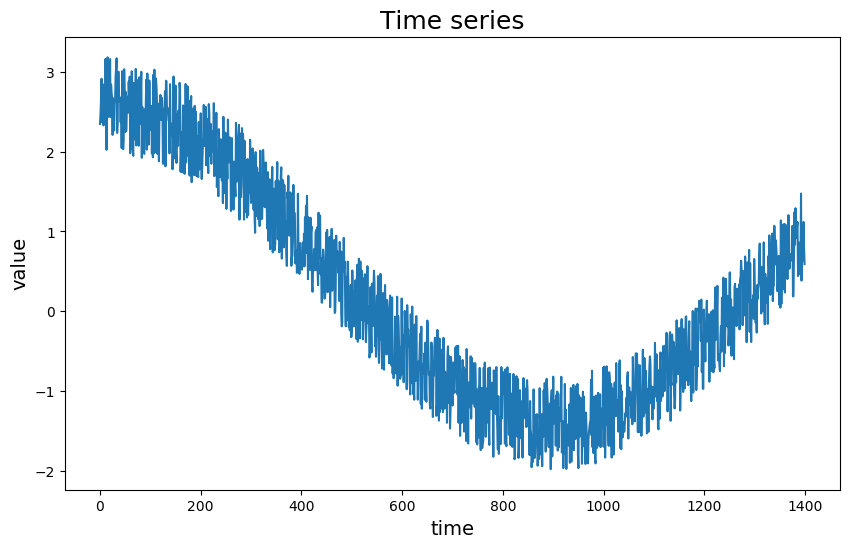

In [34]:
### Create time series and save it as Pandas' dataframe

# Time interval (t(0)=0) and time step
t_max = 1400   # s
dt_series = 1   # s

time_vector = []
series_vector = []
for T in np.arange(0.0, t_max, dt_series):
    series_value = create_time_series(T)
    series_vector.append(series_value)
    time_vector.append(T)

    
# save time series as pandas dataframe
time_series = pd.DataFrame({'time':time_vector,'value':series_vector})
# time_serie.describe()


# plot the time series
plot_time_series(time_series['time'],time_series['value'])

### Implementation of the SAX method

The SAX method is here implemented as described in the introduction. The method consists of two main steps: generation of the PAA representation and mapping PAA to the SAX alphabet. The method is implemented using the following functions: 

- *generate_PAA* : convert the (original) time series into its PAA representation using $w$ time intervals
- *generate_SAX* : maps the PAA representation into the SAX word given the cardinality $a$
- *SAX_method* : runs the SAX method by calling the previous two functions in the same order
- *get_sax_symbol_freq* : calculates frequencies of SAX symbols





In [35]:
### Function for STEP 1: generation of PAA

from sklearn import preprocessing

# Convert input time series into PAA representation of size w (number of time intervals)
def generate_PAA(w,T_input):
    
    # Standardization of the signal (writing it as z-value series)
    scaler = preprocessing.StandardScaler().fit(T_input['value'])
    series_standard = scaler.transform(T_input['value'])


    # Application of the Piecewise Aggregate Approximation (PAA)
    time_min = np.min(T_input['time'])
    time_max = np.max(T_input['time'])
    dt_PAA = (time_max - time_min) / w
    num_values_interval = dt_PAA / dt_series


    series_PAA_time = []
    series_PAA_vector = []
    idx_min = 0
    idx_max = 0
    for i in range(w):
        
        # select new time range and compute average signal value
        idx_min = math.ceil(i * num_values_interval)
        idx_max = math.ceil((i + 1) * num_values_interval)
        if idx_max>=(time_max / dt_series):
            avg_value = np.mean(series_standard[idx_min:])
        else:
            avg_value = np.mean(series_standard[idx_min:idx_max])
        time_int = (i+1) * dt_PAA

        # save average info
        series_PAA_time.append(time_int)
        series_PAA_vector.append(avg_value)

    
    # save PAA as pandas dataframe
    time_series_PAA = pd.DataFrame({'time':series_PAA_time,'value':series_PAA_vector})
    
    # return output: PAA seties and standardized time serie
    return time_series_PAA, series_standard



In [1]:
### Function for STEP 2: mapping PAA to SAX alphabet

from scipy.stats import norm

# Returns the interval (defined by (a-1) breakpoints) where the input element lies
def find_interval(element,B_list):
    
    # call recursive function that searches in which interval the input element lies
    return search_interval(element,0,B_list)



# Search the breakpoint interval where the input element lies
def search_interval(element,index_Breakpoint,B_list):
    
    # exit condition of recursive function
    if index_Breakpoint==(len(B_list)):
        return len(B_list)
    
    elif element<=B_list[index_Breakpoint]:
        return index_Breakpoint
    
    else:
        interval_idx = search_interval(element,index_Breakpoint+1,B_list)
        return interval_idx
    
    
    
# Maps interval number to its binary representation (SAX symbol)
def get_SAX_symbol(interval_Number,a_cardinality):
    
    # This function was created according to Fig. 3 and Table 3 of Ref [1]
    n_bits = int(np.ceil(math.log2(a_cardinality)))
    string = "{0:0"+str(n_bits)+"b}"
    symbol = string.format(interval_Number)
    
    return symbol



# Convert PAA series into SAX word of cardinality a
def generate_SAX(a,T_PAA):

    # Create set of ordered breakpoints that splits the N(0,1) curve into 'a' portions of equal area
    pct_step = 1 / a
    myList = [(i*pct_step) for i in range(1,a)]

    Breakpoints_list = []
    for h in myList:
        B = norm.ppf(h)
        if B!=math.inf:
            Breakpoints_list.append(B)

    
    w = len(T_PAA)
    SAX_vector = []
    SAX_interval = []
    for PAA_value in T_PAA['value']:
        interval = find_interval(PAA_value,Breakpoints_list)
        symbol = get_SAX_symbol(interval,a)
        SAX_vector.append(symbol)
        SAX_interval.append(interval)
        
    return SAX_vector, Breakpoints_list, SAX_interval

        
    
# function that runs the whole SAX method    
def SAX_method(T,w,a):
    
    # STEP 1: convert time series into PAA representation
    time_series_PAA, series_standard = generate_PAA(w,T)
    
    # STEP 2: mapping into SAX alphabet
    SAX_word, Breakpoints, SAX_interval = generate_SAX(a,time_series_PAA)
    
    # add info to PAA dataframe to summarize the results
    time_series_PAA['interval'] = pd.Series(SAX_interval, index=time_series_PAA.index)
    time_series_PAA['SAX'] = pd.Series(SAX_word, index=time_series_PAA.index)
    print('Summary of SAX representation of the time series (value = z-value of PAA)\n')
    print(time_series_PAA)
    
    # plot PAA and SAX representation
    plot_time_series_SAX(time_series_PAA,time_series['time'],series_standard,Breakpoints)
    
    return SAX_word, Breakpoints



In [37]:
### Function that calculates frequencies of the SAX symbols

from collections import Counter

# Calculate frequency of SAX symbols
def get_sax_symbol_freq(SAX_symbol_word,cardinality):
    
    symbol_list = []
    for a in range(cardinality):
        symbol = get_SAX_symbol(a,cardinality)
        symbol_list.append(symbol)
        
    # compute frequency
    counts = Counter(SAX_word)
    frequency = {}
    for symbol in symbol_list:
        if symbol in counts:
            frequency[symbol] = counts[symbol]
        else:
            frequency[symbol] = 0
            
    print('Frequency of SAX symbols\n')
    print(frequency)
    
    # Plot histogram of frequencies
    font_size = 14
    plt.figure(num=None, figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k')
    plt.bar(range(len(frequency)), frequency.values(), align='center')
    plt.xticks(range(len(frequency)), frequency.keys())
    plt.xlabel('SAX symbols',fontsize = font_size)
    plt.ylabel('frequency',fontsize = font_size)
    plt.title('Frequencies of the SAX symbols',fontsize = font_size+4)
    plt.show()
    
    return frequency, symbol_list

### Application of the SAX method

Summary of SAX representation of the time series (value = z-value of PAA)

     time     value  interval  SAX
0   139.9  1.704519         5  101
1   279.8  1.359486         5  101
2   419.7  0.782631         4  100
3   559.6  0.073398         3  011
4   699.5 -0.572052         1  001
5   839.4 -0.964818         1  001
6   979.3 -1.163777         0  000
7  1119.2 -0.972311         0  000
8  1259.1 -0.449218         1  001
9  1399.0  0.202143         3  011


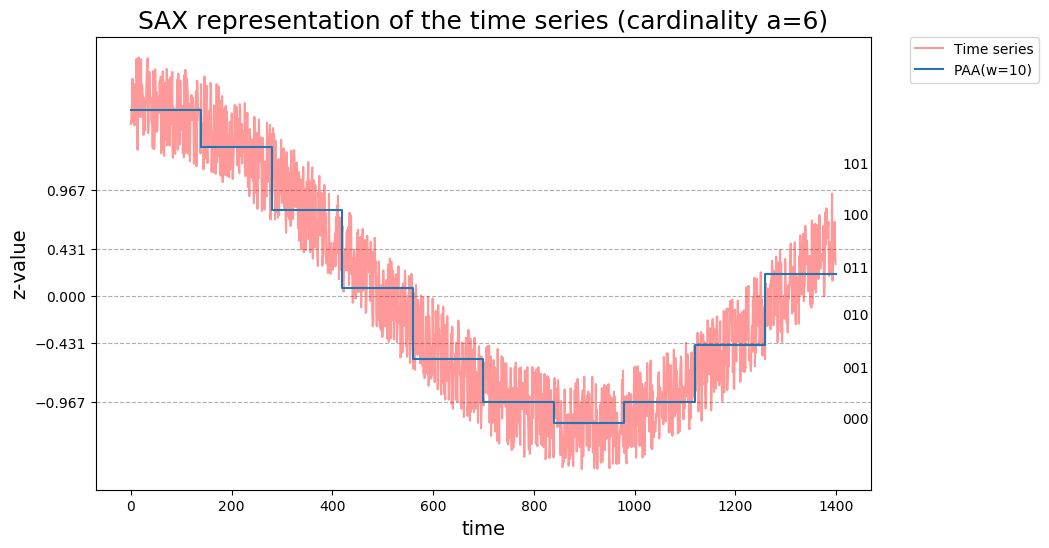

Frequency of SAX symbols

{'000': 2, '001': 3, '010': 0, '011': 2, '100': 1, '101': 2}


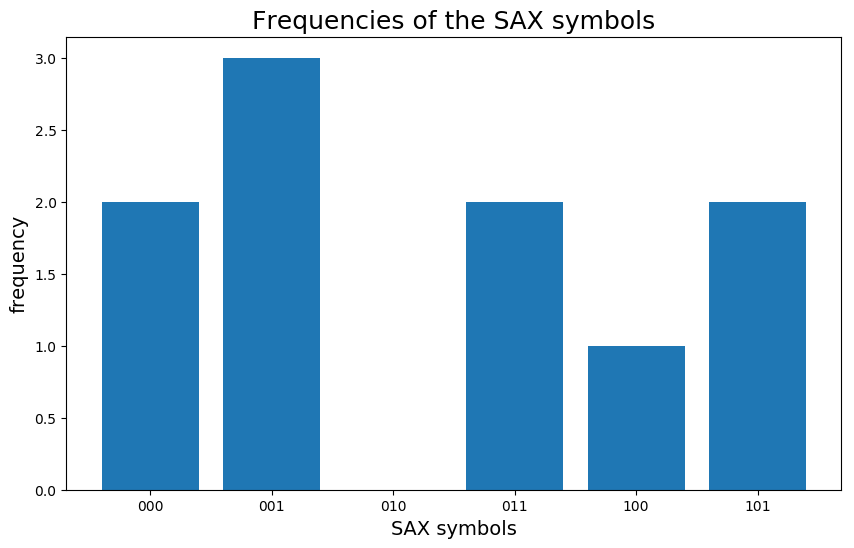

In [39]:
### Apply SAX mining to time series 


w_PAA = 10   # Number of time intervals for PAA
a_SAX = 6    # cardinality for SAX representation


# apply SAX
SAX_word, Breakpoints = SAX_method(time_series,w_PAA,a_SAX)


# compute frequencies of SAX symbols
SAX_freq, symbol_list = get_sax_symbol_freq(SAX_word,a_SAX)

## Implementation of a Piecewise Linear Approximation

The **Sliding Windows** algorithm is a particular Piecewise Approximation technique [2]. Similarly to SAX, Sliding Windows is a *data-adaptive* approach. This algorithms generates a picewise linear representation of the time series while retaining its essential features.

The Sliding Windows algorithm works by anchoring the left point of a potential segment at the first data of the series. The segment is grown from the anchor until the fit error (squared error of the linear regression) it exceeds some error threshold. The segment that approximates the portion of the time series is obtained by applying the linear regression technique to the considered portion of series. If the fit error exceeds the error threshold, the anchor is moved to the last point of the series portion.


### Implementation of the Sliding Windows algorithm

The Sliding Windows algorithm consists of the following two functions:

- *leastsquareslinefit*: calculates the trend line and the fit error via linear regression analysis of a portion of time series
- *sliding_PLA*: main loop of the sliding windows algorithm. Grows the segment until the fit error of the linear regression exceeds the error threshold. If so, start a new segment by anchoring the last point of the previous interval of the series. 

The final output is a list of segments representing the time series. Each segment is defined as $[t_0,y_0,t_1,y_1]$, with $(t_0,y_0)$ and $(t_1,y_1)$ endpoints of the segment.

Note that the following implementation is not optimized for speed, memory, recursion. 


In [40]:
from numpy import arange, array, ones
from numpy.linalg import lstsq

# Plot of the reduced time series
def plot_time_series_segments(t,y,segments):
    font_size = 14

    plt.figure(num=None, figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k')
    plt.plot(t, y,alpha = 0.4, color = 'r',label='Time series')
    plt.xlabel('time',fontsize = font_size)
    plt.ylabel('z-value',fontsize = font_size)
    plt.title('Piecewise Linear Polynomial approximation of the time series',fontsize = font_size+4)
    for segment in segments:
        plt.plot([segment[0], segment[2]], [segment[1], segment[3]], 'b-',alpha = 1)
        
    plt.plot([segment[0], segment[2]], [segment[1], segment[3]], 'b-',alpha = 1, label = 'PLA')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    
# linear regression via least squares
def leastsquareslinefit(T_df,idx0,idxF):
    """Return the parameters and error for a least squares line fit of one segment of a sequence"""
    x = arange(T_df['time'][idx0],T_df['time'][idxF])
    y = array(T_df['zvalue'][idx0:idxF])
    A = ones((len(x),2),float)
    A[:,0] = x
    (p,residuals,rank,s) = lstsq(A,y)
    try:
        error = residuals[0]
    except IndexError:
        error = 0.0
    return (p,error)



# Sliding Windows Piecewise Linear Approximation technique
def sliding_PLA(max_error,T_series):
    
    size_T = len(T_series['zvalue'])
    
    anchor = 0
    end = anchor
    segment_list = []

    # start main loop
    while end<(size_T-1):
        i = 1 
        m, error = leastsquareslinefit(T_series,anchor,anchor+i)   # check fit error

        # grows segment until the fit error exceeds the threshold
        while error<max_error and (anchor+i)<(size_T-1):
            i = i + 1
            m, error = leastsquareslinefit(T_series,anchor,anchor+i)

        # create linear approximation of the series portion
        t0 = T_series['time'][anchor]
        t1 = T_series['time'][anchor+i]
        y0 = m[0]*t0 + m[1] 
        y1 = m[0]*t1 + m[1] 
        
        # save fit line
        segment = (t0,y0,t1,y1)
        segment_list.append(segment)
        
        # move anchor
        end = anchor + i
        anchor = end
        
    return segment_list


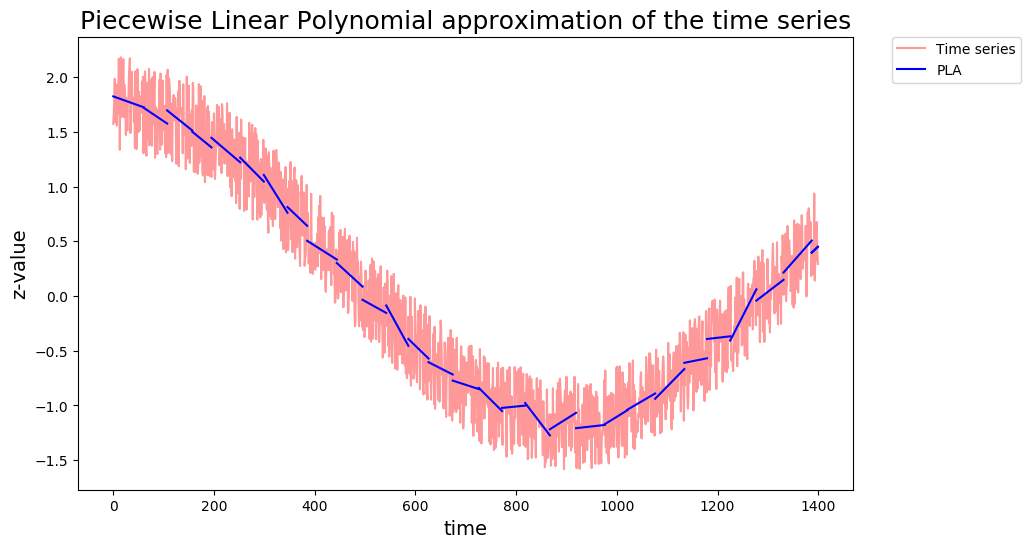

The time series is represented by 29 segments.




In [66]:
# Standardization of the time series (writing it as z-value series)
series_standard = preprocessing.StandardScaler().fit_transform(time_series['value'])
time_series['zvalue'] = pd.Series(series_standard, index=time_series.index)

error_threshold = 3

# call PLA sliding windows algorithm
segment_list = sliding_PLA(error_threshold,time_series)
    
plot_time_series_segments(time_series['time'],time_series['zvalue'],segment_list)

print('The time series is represented by '+str(len(segment_list)) + ' segments.')
print('\n')

In the Sliding Windows algorithm, the number of segments is not an input of the algorithm (as PAA), but depends on the error threshold defined by the user, which is the only input of the algorithm.

## Graphical interface for SAX representation

The key idea behind SAX is to represent the original time series in a more compact way to allow efficient storage and processing without loosing the key information (or shape) of the signal. To show these two key features, the following plots are generated:

1. Original time series and its PAA/SAX representation
2. Frequency of the time series values and its SAX representation
3. Size of the storing vector

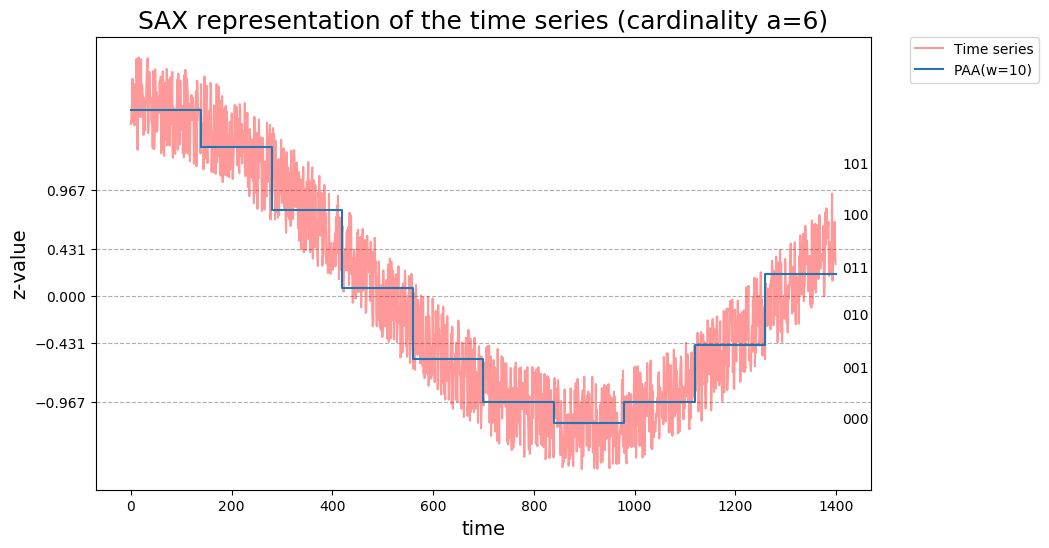

SAX_word : 
['101', '101', '100', '011', '001', '001', '000', '000', '001', '011']


In [59]:
# PLOT 1: original time series and its PAA and SAX representation

time_series_PAA, series_standard = generate_PAA(w_PAA,time_series)
SAX_word, Breakpoints, SAX_interval = generate_SAX(a_SAX,time_series_PAA)
plot_time_series_SAX(time_series_PAA,time_series['time'],series_standard,Breakpoints)

print('SAX_word : ')
print(SAX_word)

The previous plots shows the original time series and its PAA representation. The time series consists of $n$ measured values. Notably, PAA represents the signal with a vector of size $w<<n$, containing the ordered average values of the time series in each of the $w$ intervals of width $t_{max}/w$. 

The PAA vector is mapped into the SAX symbols. Every SAX symbol represents one of the $a$ intervals that discretizes the values of the time series. The final time series representation is a SAX word (or ordered vector) of length $w$, where each element is the SAX symbol representing the interval in which the value of the PAA lies. 

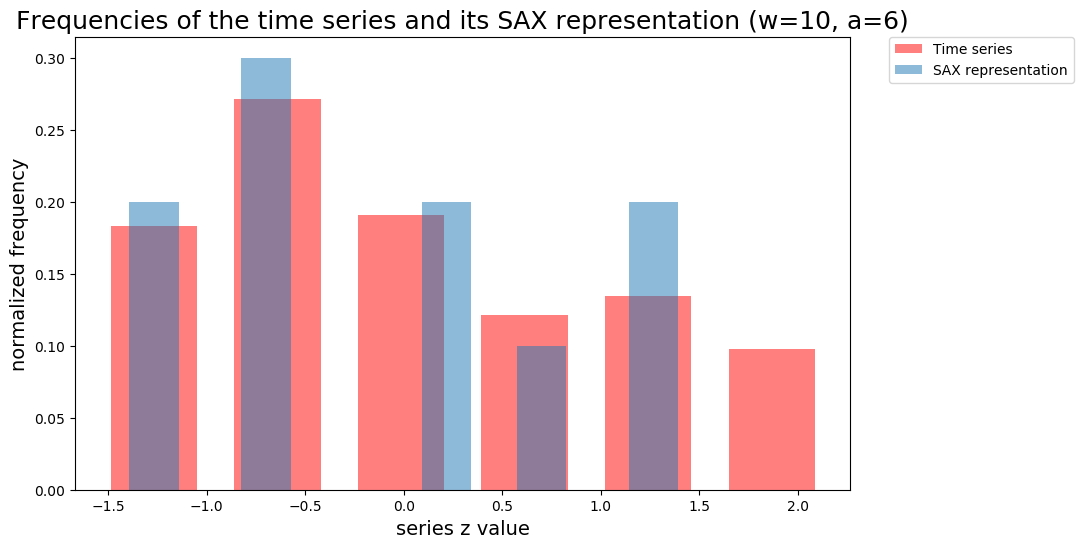

In [62]:
# PLOT 2: frequencies of the series and SAX values

freq = []
bar_position = []
for i in range(len(Breakpoints)+1):
    if i==0:
        bar_position.append(Breakpoints[0] - 0.3)
        freq.append(SAX_freq[symbol_list[0]]/w_PAA)
    elif i==(len(Breakpoints)):
        bar_position.append(Breakpoints[-1] + 0.3)
        freq.append(SAX_freq[symbol_list[-1]]/w_PAA)
    else:
        bar_position.append(0.5 * (Breakpoints[i] + Breakpoints[i - 1]))
        freq.append(SAX_freq[symbol_list[i]]/w_PAA)
    

# Plot histograms
width = 0.25       # the width of the bars: can also be len(x) sequence
font_size = 14


plt.figure(num=None, figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k')

weights = np.ones_like(time_series['zvalue'])/float(len(time_series['zvalue']))
plt.hist(time_series['zvalue'], bins = a_SAX,  weights=weights, color = 'r', rwidth = 0.7, alpha = 0.5, label = 'Time series')

plt.bar(bar_position, freq, width, alpha = 0.5, label = 'SAX representation')
#plt.xticks(range(len(frequency)), frequency.keys())
plt.xlabel('series z value',fontsize = font_size)
plt.ylabel('normalized frequency',fontsize = font_size)
plt.title('Frequencies of the time series and its SAX representation (w='+str(w_PAA)+', a='+str(a_SAX)+')',fontsize = font_size+4)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()    
    
 

The previous histogram compares the frequencies of values of the original time series with the frequencies of the SAX representation. This plots shows one of the key features of the SAX representation: the key information of the signal is preserved as the distribution of the frequencies for SAX and original time series are comparable.

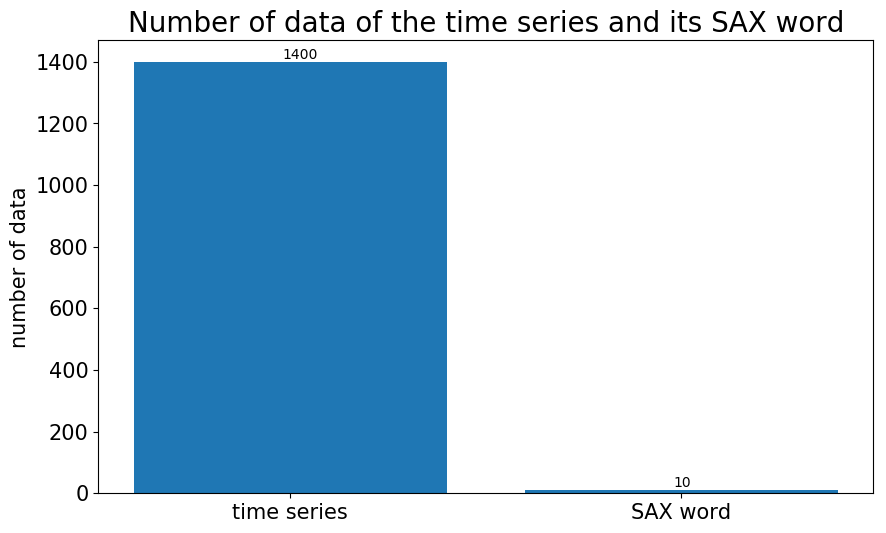

In [86]:
# PLOT 3: size of the time series

length_time_series = len(time_series['zvalue'])
length_SAX_word = w_PAA

plt.figure(num=None, figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k')

plt.bar([1,2],[length_time_series,length_SAX_word])
plt.title('Number of data of the time series and its SAX word',fontsize=20)
plt.ylabel('number of data',fontsize=15)
plt.tick_params(labelsize=15)
plt.xticks([1,2], ['time series', 'SAX word'])
plt.text(0.98,length_time_series + 10,str(length_time_series))
plt.text(1.98,length_SAX_word+10,str(length_SAX_word))
plt.show()

The previous bar plot compares the length of the original time series dataset $T$ and its SAX representation SAX($T$,$w$,$a$) with $w=10$ and $a=6$. The original dataset is 140 times larger than its SAX representaton. This means that **SAX word represents the core information of the original series in a file which is 0.7 % of the original dataset**.

## References
[1] $i$SAX: Indexing and Mining Terabyte Sized Time Series, Jin Shieh & Eamonn Keogh, SIGKDD, 2008

[2] Shatkay, H. AND Zdonik, S., "Approximate queries and representations for large data sequences." In
*Proceedings of the 12th International Conference on Data Engineering.* 536–545.